import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from src.functions.utilities import path_leaf
pyo.init_notebook_mode()

### Get list of unet training directories

In [3]:
from glob2 import glob

root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/"
unet_root = os.path.join(root, "built_image_data", "unet_training", "*")
unet_dirs = sorted(glob(unet_root))
unet_dirs = [u for u in unet_dirs if os.path.isdir(u)]

["/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/unet_training/UNET_training_bubble", "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/unet_training/UNET_training_emb", "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/unet_training/UNET_training_focus", "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/unet_training/UNET_training_yolk", "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/unet_training/_Archive"]


### iterate through each one and compile list of unique labels

In [53]:
import shutil
from tqdm import tqdm

image_root = os.path.join(root, "built_image_data", "stitched_FF_images")

for u, udir in enumerate(tqdm(unet_dirs)):
    # initialize list  to store label files
    label_path_list = []
    label_name_list = []
    # get list of subdirectories
    subdir_list = sorted(glob(os.path.join(udir, "*")))
    subdir_list = [s for s in subdir_list if os.path.isdir(s)]
    subdir_list = [s for s in subdir_list if "training" not in path_leaf(s)]
    for s, sdir in enumerate(subdir_list):
        a_dir = os.path.join(sdir, "annotations","")
        if os.path.isdir(a_dir):
            lb_files = glob(a_dir + "*.tif") + glob(a_dir + "*.jpg")
            lb_names = [path_leaf(im) for im in lb_files]
            label_path_list += lb_files
            label_name_list += lb_names

    # make new directory
    ann_dir = os.path.join(udir, "training", "annotations", "")
    if not os.path.isdir(ann_dir):
        os.makedirs(ann_dir)

    # get de-duped list of images
    lb_names_u, si_u = np.unique(label_name_list, return_index=True) 
    lb_paths_u = [label_path_list[i] for i in si_u]

    # copy over
    for i in range(len(lb_names_u)):
        shutil.copyfile(lb_paths_u[i], os.path.join(ann_dir, lb_names_u[i]))

    # make image directory
    im_dir = os.path.join(udir, "training", "images", "")
    if not os.path.isdir(im_dir):
        os.makedirs(im_dir)

    # copy images
    for i in range(len(lb_names_u)):
        date_folder = lb_names_u[i][0:8]
        im_stub = lb_names_u[i][9:18]
        im_path_from = glob(os.path.join(image_root, date_folder, im_stub + "*"))[0]
        new_name = path_leaf(im_path_from)
        im_path_to = os.path.join(im_dir, date_folder + "_" + new_name)
        shutil.copyfile(im_path_from, im_path_to)
    
    
print(label_path_list[0])

100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


IndexError: list index out of range

### Split the live and dead labels into seperate sets

In [58]:
import skimage.io as io

emb_dir = os.path.join(unet_root[:-1], "UNET_training_emb", "training") 
via_dir_lb = os.path.join(unet_root[:-1], "UNET_training_via", "training", "annotations") 
via_dir_im = os.path.join(unet_root[:-1], "UNET_training_via", "training", "images") 
if not os.path.isdir(os.path.join(via_dir_im)):
    os.makedirs(via_dir_lb)
    os.makedirs(via_dir_im)
    
mask_dir_lb = os.path.join(unet_root[:-1], "UNET_training_mask", "training", "annotations")
mask_dir_im = os.path.join(unet_root[:-1], "UNET_training_mask", "training", "images")
if not os.path.isdir(os.path.join(mask_dir_im)):
    os.makedirs(mask_dir_lb)
    os.makedirs(mask_dir_im)

label_list = sorted(glob(os.path.join(emb_dir, "annotations", "*")))
image_list = sorted(glob(os.path.join(emb_dir, "images", "*")))

for i in tqdm(range(len(image_list))):

    image_name = path_leaf(image_list[i])
    anno_path = glob(os.path.join(emb_dir, "annotations", image_name[0:19] + "*"))
    # loa
    im = io.imread(image_list[i])

    if len(anno_path) >0:
        lb = io.imread(anno_path[0])
         # make alternative labels
        lb_mask = lb.copy()
        lb_mask[lb_mask==2] = 1
    
        lb_via = lb.copy()
        lb_via[lb_via==1] = 0
        lb_via[lb_via==2] = 1

        io.imsave(os.path.join(mask_dir_lb, image_name), lb_mask, check_contrast=False)
        io.imsave(os.path.join(via_dir_lb, image_name), lb_via, check_contrast=False)
        
    # save
    io.imsave(os.path.join(mask_dir_im, image_name), im, check_contrast=False)
    io.imsave(os.path.join(via_dir_im, image_name), im, check_contrast=False)

100%|██████████| 297/297 [00:42<00:00,  7.02it/s]


In [57]:
/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/unet_training/UNET_training_emb/training/annotations/

"/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/unet_training/UNET_training_emb/training/annotations/20230629_G03_t0029_stitch*"

In [23]:
import math
from tqdm import tqdm

def make_rotating_figure(fig, angle_vec, frame_dir, marker_opacity=0.5, marker_size=6, color_var=None):

    if color_var is None:
        color_var = "predicted_stage_hpf"
        
    for iter_i, a in enumerate(tqdm(angle_vec)):
        angle = a
        za = 0.2
        vec = np.asarray([math.cos(angle), math.sin(angle), za])
        vec = vec*2
        camera = dict(
            eye=dict(x=vec[0], y=vec[1], z=vec[2]))
        
        # fig = px.scatter_3d(plot_df, x="UMAP_00_bio_3", y="UMAP_01_bio_3", z="UMAP_02_bio_3",
        #                     color=color_var, opacity=marker_opacity,
        #                     labels={'predicted_stage_hpf': "age (hpf)",
        #                             'master_perturbation': "genotype"})
        
        # fig.update_traces(marker={'size': marker_size})
        
        fig.update_layout(template="plotly")

        fig.update_layout(scene_camera=camera, scene_dragmode='orbit')

        fig.update_layout(scene = dict(
                        # xaxis_title='UMAP 1',
                        # yaxis_title='UMAP 2',
                        # zaxis_title='UMAP 3',
                        xaxis = dict(showticklabels=False),
                        yaxis = dict(showticklabels=False),
                        zaxis = dict(showticklabels=False)))

#         fig.update_layout(coloraxis_showscale=False)
        
#         fig.update_layout(
#                 scene=dict(aspectratio=dict(x=1, y=1, z=1))
#         )

        fig.write_image(os.path.join(frame_dir, "umap_scatter" + "_" + color_var + f"_{iter_i:03}" + ".png"), scale=2)
            
    return fig

### Calculate morphological velocities

In [24]:
from tqdm import tqdm

# calculate per-point velocity for each embryo
snip_vec = np.asarray([umap_df.loc[i, "snip_id"][:-10] for i in range(umap_df.shape[0])])
umap_df["embryo_id"] = snip_vec
snip_index = np.unique(snip_vec)

umap_df.loc[:, "UMAP_00_3_vel"] = np.nan
umap_df.loc[:, "UMAP_01_3_vel"] = np.nan
umap_df.loc[:, "UMAP_02_3_vel"] = np.nan

for s, snip in enumerate(tqdm(snip_index, "Extracting embryo velocities...")):
    s_indices = np.where(snip_vec==snip)[0]
    
    u0 = umap_df.loc[s_indices, "umap0"].to_numpy()
    u1 = umap_df.loc[s_indices, "umap1"].to_numpy()
    u2 = umap_df.loc[s_indices, "umap2"].to_numpy()

    if len(u0) > 5:
    
        t = umap_df.loc[s_indices, "inferred_stage_hpf_reg"].to_numpy()
        
        du0 = np.divide(np.diff(u0), np.diff(t))
        du1 = np.divide(np.diff(u1), np.diff(t))
        du2 = np.divide(np.diff(u2), np.diff(t))
        
        umap_df.loc[s_indices[:-1], "UMAP_00_3_vel"] = du0
        umap_df.loc[s_indices[:-1], "UMAP_01_3_vel"] = du1
        umap_df.loc[s_indices[:-1], "UMAP_02_3_vel"] = du2
    
        umap_df.loc[s_indices[-1], "UMAP_00_3_vel"] = du0[-1]
        umap_df.loc[s_indices[-1], "UMAP_01_3_vel"] = du1[-1]
        umap_df.loc[s_indices[-1], "UMAP_02_3_vel"] = du2[-1]

# remove frames with not velocity
print(umap_df.shape[0])
umap_df = umap_df.loc[~np.isnan(umap_df["UMAP_00_3_vel"])]
print(umap_df.shape[0])

Extracting embryo velocities...:  89%|████████▉ | 1423/1592 [00:02<00:00, 509.39it/s]/tmp/ipykernel_586625/4263004075.py:23: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_586625/4263004075.py:24: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_586625/4263004075.py:25: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_586625/4263004075.py:23: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_586625/4263004075.py:24: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_586625/4263004075.py:25: RuntimeWarning:

divide by zero encountered in divide

Extracting embryo velocities...: 100%|██████████| 1592/1592 [00:02<00:00, 535.79it/s]

54195
53774


In [25]:
from sklearn.cluster import KMeans
pert_vec = umap_df.loc[:, "master_perturbation"].to_numpy()
pert_index = np.unique(umap_df["master_perturbation"])
cluster_size = 25
max_pert_clusters = 500
min_pert_clusters = 10
train_filter = True#umap_df["train_cat"]=="train"
cluster_df_list = []

for p, pert in enumerate(tqdm(pert_index, "Clustering perturbation data...")):

    # pull out raw umap coordinates
    df_filter = (pert_vec == pert) & train_filter
    umap_array = umap_df.loc[df_filter, ["umap0", "umap1", "umap2"]].to_numpy()
    umap_v_array = umap_df.loc[df_filter, ["UMAP_00_3_vel", "UMAP_01_3_vel", "UMAP_02_3_vel"]].to_numpy()
    age_vec = umap_df.loc[df_filter, "inferred_stage_hpf_reg"].to_numpy()
    n_points = umap_array.shape[0]
    
    n_clusters = np.min([int(np.round(n_points/cluster_size)), max_pert_clusters])
    if n_clusters > min_pert_clusters:
    
        # cluster
        kmeans_out = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(umap_array)
        label_vec = kmeans_out.labels_

        label_index, ia, label_counts = np.unique(label_vec, return_counts=True, return_inverse=True)
        
        umap_df.loc[df_filter, "kmeans_label"] = label_vec
        umap_df.loc[df_filter, "cluster_counts"] = label_counts[ia]
    
        
        if pert=="wik":
            label_index = label_index[label_counts>35]
            label_counts = label_counts[label_counts>35]
        else:
            label_index = label_index[label_counts>15]
            label_counts = label_counts[label_counts>15]
        
        k_df = pd.DataFrame(label_index, columns=["kmeans_label"])
        k_df["cluster_counts"] = label_counts
        k_df["master_perturbation"] = pert
        k_df["n_clusters"] = n_clusters
        for l, lb in enumerate(label_index):
            
            k_df.loc[l, "X"] = np.mean(umap_array[label_vec==lb, 0])
            k_df.loc[l, "Y"] = np.mean(umap_array[label_vec==lb, 1])
            k_df.loc[l, "Z"] = np.mean(umap_array[label_vec==lb, 2])
    
            k_df.loc[l, "dX"] = np.mean(umap_v_array[label_vec==lb, 0])
            k_df.loc[l, "dY"] = np.mean(umap_v_array[label_vec==lb, 1])
            k_df.loc[l, "dZ"] = np.mean(umap_v_array[label_vec==lb, 2])

            k_df.loc[l, "stage_hpf"] = np.mean(age_vec[label_vec==lb])
    
        cluster_df_list.append(k_df)


cluster_df = pd.concat(cluster_df_list, axis=0, ignore_index=True)

Clustering perturbation data...: 100%|██████████| 29/29 [00:01<00:00, 17.78it/s]


In [26]:
min_stage = np.min(cluster_df["stage_hpf"])
max_stage = np.max(cluster_df["stage_hpf"])
stage_range = max_stage - min_stage
cluster_df["stage_norm"] = (cluster_df["stage_hpf"] - min_stage) / stage_range  / 0.5
offset_factor = 1

cluster_df["vel_norm"] = np.sqrt(cluster_df["dX"]**2 + cluster_df["dY"]**2 + cluster_df["dZ"]**2)

# age scaling
cluster_df["dX_norm"] = np.multiply(np.divide(cluster_df["dX"], cluster_df["vel_norm"]), cluster_df["stage_norm"]) + \
                            np.multiply(np.divide(cluster_df["dX"], cluster_df["vel_norm"]), offset_factor) 
cluster_df["dY_norm"] = np.multiply(np.divide(cluster_df["dY"], cluster_df["vel_norm"]), cluster_df["stage_norm"]) + \
                            np.multiply(np.divide(cluster_df["dY"], cluster_df["vel_norm"]), offset_factor) 
cluster_df["dZ_norm"] = np.multiply(np.divide(cluster_df["dZ"], cluster_df["vel_norm"]), cluster_df["stage_norm"]) + \
                            np.multiply(np.divide(cluster_df["dZ"], cluster_df["vel_norm"]), offset_factor) 

# adjust outlier velocities
# norm_vec = cluster_df["vel_norm"] / max_v 
# norm_vec[norm_vec<1] = 1
# density_norm = cluster_df["n_clusters"] / np.max(cluster_df["n_clusters"])

# cluster_df["dX_norm2"] = np.divide(np.divide(cluster_df["dX"], norm_vec), density_norm)
# cluster_df["dY_norm2"] = np.divide(np.divide(cluster_df["dY"], norm_vec), density_norm)
# cluster_df["dZ_norm2"] = np.divide(np.divide(cluster_df["dZ"], norm_vec), density_norm)

# cluster_df["dX_norm"] = np.divide(cluster_df["dX_norm"], local_density)
# cluster_df["dY_norm"] = np.divide(cluster_df["dY_norm"], local_density)
# cluster_df["dZ_norm"] = np.divide(cluster_df["dZ_norm"], local_density)

In [57]:
local_density

array([0.3423824 , 0.26859846, 0.34590885, ..., 0.33709884, 0.71624662,
       0.21156952])

### Make 3D scatter plots

In [27]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.express.colors import sample_colorscale
import sklearn


NameError: name 'g' is not defined

### Make cone plots

100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


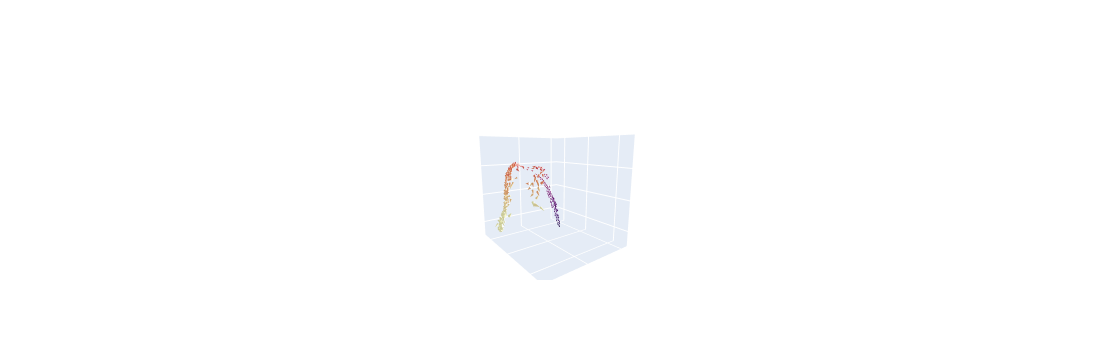

In [28]:


x = np.linspace(0, 1, 100)
c = sample_colorscale('magma', list(x))

pert = "wik"#, "gdf3", 'TGFB-i', "tbxta"]
# c = "magma"#, "Reds", "Purples", "Greens"]

# size_ref_vec = np.linspace(1, 4.5, 50).tolist() + 40*[4.5]
# cmax = 9
angle_vec = np.linspace(5.51, 2*np.pi + 5.51, 50)
cone_path = os.path.join(figure_path, "cone_frames_wt_magma", "")
if not os.path.isdir(cone_path):
    os.makedirs(cone_path)

# times_to_plot = np.linspace(18, 56, 50)
# times_to_plot[-1] = 72


# for t, time in enumerate(tqdm(times_to_plot, "Generating cone plots....")):
df = cluster_df.copy()#.loc[cluster_df["master_perturbation"]==pert,:]

df.loc[cluster_df["master_perturbation"]!=pert,["dZ_norm"]] = 0
df.loc[cluster_df["master_perturbation"]!=pert,["dY_norm"]] = 0
df.loc[cluster_df["master_perturbation"]!=pert,["dX_norm"]] = 0

# n=10
# dist_mat = sklearn.metrics.pairwise_distances(df.loc[:, ["X", "Y", "Z"]].to_numpy())
# dist_mat_sorted = np.sort(dist_mat, axis=1)
# local_density = np.mean(dist_mat_sorted[:, 1:n+1], axis=1)

# df["dX_norm2"] = np.divide(df["dX_norm"], local_density)
# df["dY_norm2"] = np.divide(df["dY_norm"], local_density)
# df["dZ_norm2"] = np.divide(df["dZ_norm"], local_density)

fig = go.Figure()

fig.update_layout(scene = dict(
                xaxis_title='',
                yaxis_title='',
                zaxis_title='',
                xaxis = dict(showticklabels=False),
                yaxis = dict(showticklabels=False),
                zaxis = dict(showticklabels=False)))

angle = angle_vec[0]
za = 0.2
vec = np.asarray([math.cos(angle), math.sin(angle), za])
vec = vec*2
camera = dict(
eye=dict(x=vec[0], y=vec[1], z=vec[2]))
    
lim_scene =  dict(
                xaxis = dict(nticks=4, range=[-2, 12],),
                yaxis = dict(nticks=4, range=[-10, 12],),
                zaxis = dict(nticks=4, range=[-7.5, 10],),)

fig.update_layout(scene_camera=camera, scene_dragmode='orbit')
    #define the trace for triangle sides
cones = go.Cone(
    x=df["Z"],
    y=df["X"],
    z=df["Y"],
    u=df["dZ_norm"],
    v=df["dX_norm"],
    w=df["dY_norm"],
    colorscale="magma",
    sizemode="absolute",
    sizeref=4.5, 
    # cauto=True,
    cmin=0.8,
    cmax=2,
    # anchor="tip",
    showscale=False,
lighting_specular=2)
    
fig.add_trace(cones)
# fig.update_layout(
# autosize=False,
# width=1500,
# height=1500)
fig.update_layout(scene=lim_scene)

fig = make_rotating_figure(fig, angle_vec[:2], cone_path)
# fig.write_image(os.path.join(figure_path, "cone_cb.png"), scale=3)


fig.show()

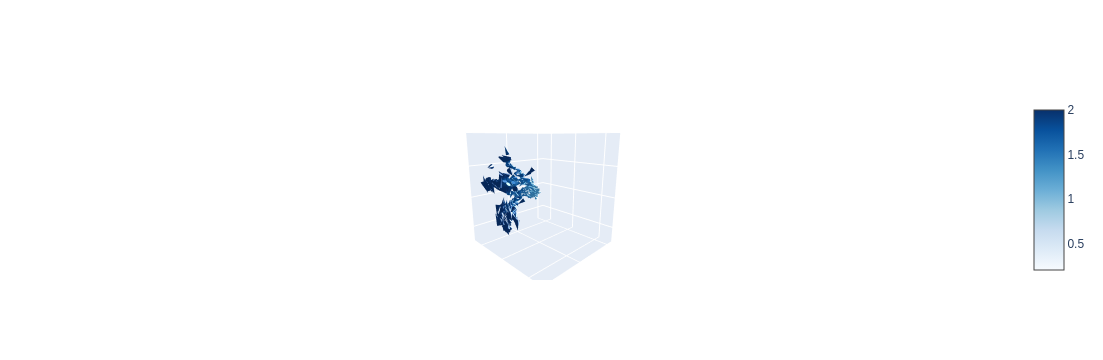

In [16]:
pert = "wik"#, "gdf3", 'TGFB-i', "tbxta"]
# c = "magma"#, "Reds", "Purples", "Greens"]

# size_ref_vec = np.linspace(1, 4.5, 50).tolist() + 40*[4.5]
# cmax = 9
cone_path = os.path.join(figure_path, "cone_frames_wt_magma", "")
if not os.path.isdir(cone_path):
    os.makedirs(cone_path)

# times_to_plot = np.linspace(18, 56, 50)
# times_to_plot[-1] = 72


# for t, time in enumerate(tqdm(times_to_plot, "Generating cone plots....")):
df = cluster_df.copy()#.loc[cluster_df["master_perturbation"]==pert,:]

df.loc[cluster_df["master_perturbation"]!=pert,["dZ_norm"]] = 0
df.loc[cluster_df["master_perturbation"]!=pert,["dY_norm"]] = 0
df.loc[cluster_df["master_perturbation"]!=pert,["dX_norm"]] = 0

# n=10
# dist_mat = sklearn.metrics.pairwise_distances(df.loc[:, ["X", "Y", "Z"]].to_numpy())
# dist_mat_sorted = np.sort(dist_mat, axis=1)
# local_density = np.mean(dist_mat_sorted[:, 1:n+1], axis=1)

# df["dX_norm2"] = np.divide(df["dX_norm"], local_density)
# df["dY_norm2"] = np.divide(df["dY_norm"], local_density)
# df["dZ_norm2"] = np.divide(df["dZ_norm"], local_density)

fig = go.Figure()

fig.update_layout(scene = dict(
                xaxis_title='',
                yaxis_title='',
                zaxis_title='',
                xaxis = dict(showticklabels=False),
                yaxis = dict(showticklabels=False),
                zaxis = dict(showticklabels=False)))

angle = angle_vec[0]
za = 0.25
vec = np.asarray([math.cos(angle), math.sin(angle), za])
vec = vec*2
camera = dict(
eye=dict(x=vec[0], y=vec[1], z=vec[2]))
    
lim_scene =  dict(
                xaxis = dict(nticks=4, range=[-2, 12],),
                yaxis = dict(nticks=4, range=[-10, 12],),
                zaxis = dict(nticks=4, range=[-7.5, 10],),)

fig.update_layout(scene_camera=camera, scene_dragmode='orbit')
    #define the trace for triangle sides
cones = go.Cone(
    x=df["Z"],
    y=df["X"],
    z=df["Y"],
    u=df["dZ_norm"],
    v=df["dX_norm"],
    w=df["dY_norm"],
    colorscale="Blues",
    sizemode="absolute",
    sizeref=4.5, 
    # cauto=True,
    cmin=0.2,
    cmax=2,
    # anchor="tip",
    showscale=True,
lighting_specular=2)
    
fig.add_trace(cones)
# fig.update_layout(
# autosize=False,
# width=1500,
# height=1500)
fig.update_layout(scene=lim_scene)

# fig = make_rotating_figure(fig, angle_vec, cone_path)
fig.write_image(os.path.join(figure_path, "cone_plot_blue.png"), scale=3)


fig.show()

100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


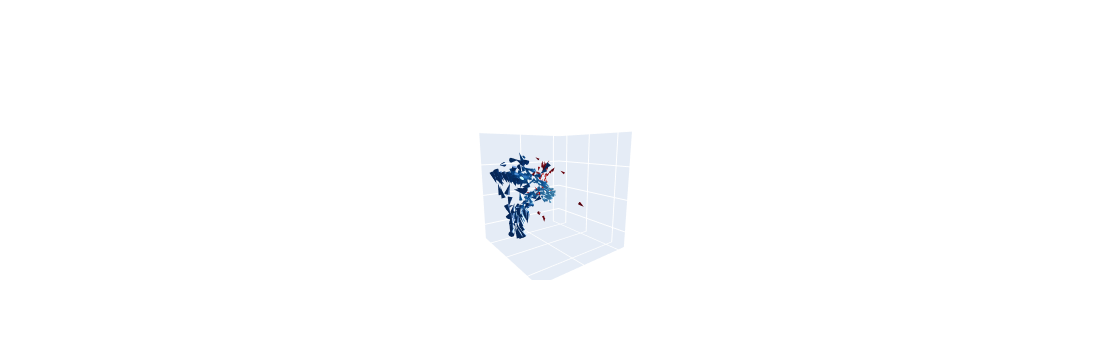

In [17]:
pert_to_plot = ["wik", "TGFB-i"] #, 'gdf3'] #'TGFB-i', "tbxta"]
c_vec = ["Blues", "Reds"] #, "Reds"]# "Greens"]
size_ref_vec = np.asarray([4.5/2.5, .6, 0.95, 5])*2.5
c_max_vec = np.asarray([2, 2, 2, 1.5])*1
c_min_vec = np.asarray([0.2, 0, 0.1, 1.5])
fig = go.Figure()

for p, pert in enumerate(pert_to_plot):

    df = cluster_df.copy()#.loc[cluster_df["master_perturbation"]==pert,:]
    
    df.loc[cluster_df["master_perturbation"]!=pert,["dZ_norm"]] = 0
    df.loc[cluster_df["master_perturbation"]!=pert,["dY_norm"]] = 0
    df.loc[cluster_df["master_perturbation"]!=pert,["dX_norm"]] = 0
    
    #define the trace for triangle sides
    cones = go.Cone(
        x=df["Z"],
        y=df["X"],
        z=df["Y"],
        u=df["dZ_norm"],
        v=df["dX_norm"],
        w=df["dY_norm"],
        colorscale=c_vec[p],
        cmin=c_min_vec[p],
        cmax=c_max_vec[p],
        sizemode="absolute",
        sizeref=size_ref_vec[p], 
        showscale=False,
        anchor="tip",
    lighting_specular=2)
        
    fig.add_trace(cones)

    # fig.update_layout(
    # autosize=False,
    # width=500,
    # height=500)
    
    angle = angle_vec[0]
    za = 0.2
    vec = np.asarray([math.cos(angle), math.sin(angle), za])
    vec = vec*2
    camera = dict(
        eye=dict(x=vec[0], y=vec[1], z=vec[2]))
        

    fig.update_layout(scene_camera=camera, scene_dragmode='orbit')
    
    
    fig.update_layout(scene=lim_scene)
    fig.update_layout(scene = dict(
                    xaxis_title='',
                    yaxis_title='',
                    zaxis_title='',
                xaxis = dict(showticklabels=False),
                yaxis = dict(showticklabels=False),
                zaxis = dict(showticklabels=False)))

    fig.write_image(os.path.join(figure_path, f"pert_plot_iter{p:02}.png"), scale=3)
    

pert_path = os.path.join(figure_path, "cone_frames_pert2", "")
if not os.path.isdir(pert_path):
    os.makedirs(pert_path)

fig = make_rotating_figure(fig, angle_vec[:2], pert_path)

fig.show()

100%|██████████| 50/50 [01:35<00:00,  1.90s/it]


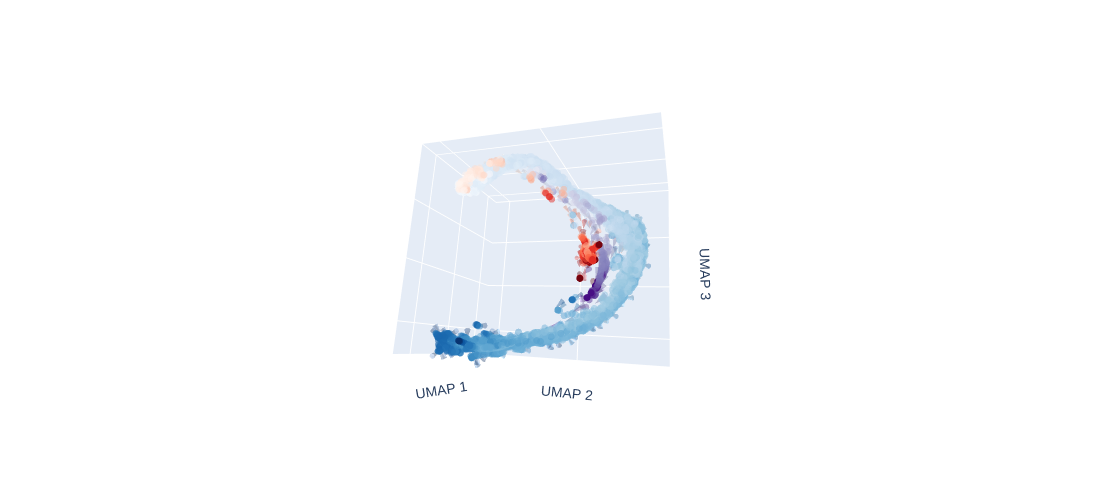

In [73]:
fig = go.Figure()

for p, pert in enumerate(pert_to_plot):

    df = cluster_df.loc[cluster_df["master_perturbation"]==pert,:] 
    
    #define the trace for triangle sides
    cones = go.Cone(
        x=df["Z"],
        y=df["X"],
        z=df["Y"],
        u=df["dZ_norm"],
        v=df["dX_norm"],
        w=df["dY_norm"],
        colorscale=c_vec[p],
        cmin=c_min_vec[p],
        cmax=c_max_vec[p],
        sizemode="absolute",
        sizeref=size_ref_vec[p], 
        showscale=False,
        opacity=0.2,
        anchor="tip",
    lighting_specular=2)
        
    fig.add_trace(cones)

    fig.update_layout(
    autosize=False,
    width=500,
    height=500)
    
    angle = angle_vec[0]
    za = 0.2
    vec = np.asarray([math.cos(angle), math.sin(angle), za])
    vec = vec*2
    camera = dict(
        eye=dict(x=vec[0], y=vec[1], z=vec[2]))
        

    fig.update_layout(scene_camera=camera, scene_dragmode='orbit')
    
    
    fig.update_layout(scene=lim_scene)
    fig.update_layout(scene = dict(
                    xaxis_title='UMAP 1',
                    yaxis_title='UMAP 2',
                    zaxis_title='UMAP 3',
                xaxis = dict(showticklabels=False),
                yaxis = dict(showticklabels=False),
                zaxis = dict(showticklabels=False)))


fig.write_image(os.path.join(figure_path, f"pert_plot_scatter_iter{0:02}.png"), scale=3)

for p, pert in enumerate(pert_to_plot):

    df = umap_df.loc[(umap_df["master_perturbation"]==pert) & (umap_df["train_cat"]!="train"),:] 
    df=df.loc[df["cluster_counts"]>25, :]
    #define the trace for triangle sides
    scatter = go.Scatter3d(
        x=df["umap2"],
        y=df["umap0"],
        z=df["umap1"],
        # u=df["dZ_norm"],
        # v=df["dX_norm"],
        # w=df["dY_norm"],
        # colorscale=c_vec[p],
        # cmin=c_min_vec[p],
        # cmax=c_max_vec[p],
        # sizemode="absolute",
        # sizeref=size_ref_vec[p], 
        mode="markers",
        marker=dict(color=df["inferred_stage_hpf_reg"], opacity=0.5, size=4, colorscale=c_vec[p]), showlegend=False)

    fig.add_trace(scatter)


    fig.write_image(os.path.join(figure_path, f"pert_plot_scatter_iter{p+1:02}.png"), scale=3)
    # lighting_specular=2)

val_path = os.path.join(figure_path, "cone_frames_validation", "")
if not os.path.isdir(val_path):
    os.makedirs(val_path)

fig = make_rotating_figure(fig, angle_vec, val_path)

fig.show()
    


In [133]:
angle

0.0